In [85]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [86]:
# Generate seasonal synthetic data
np.random.seed(0)
n = 365 * 3  # 3 years of daily data
t = np.arange(n)
seasonal_pattern = 10 * np.sin(2 * np.pi * t / 365) + 5 * np.sin(4 * np.pi * t / 365)
trend = 0.05 * t
noise = np.random.normal(0, 3.5, n)
Y = seasonal_pattern + trend + noise

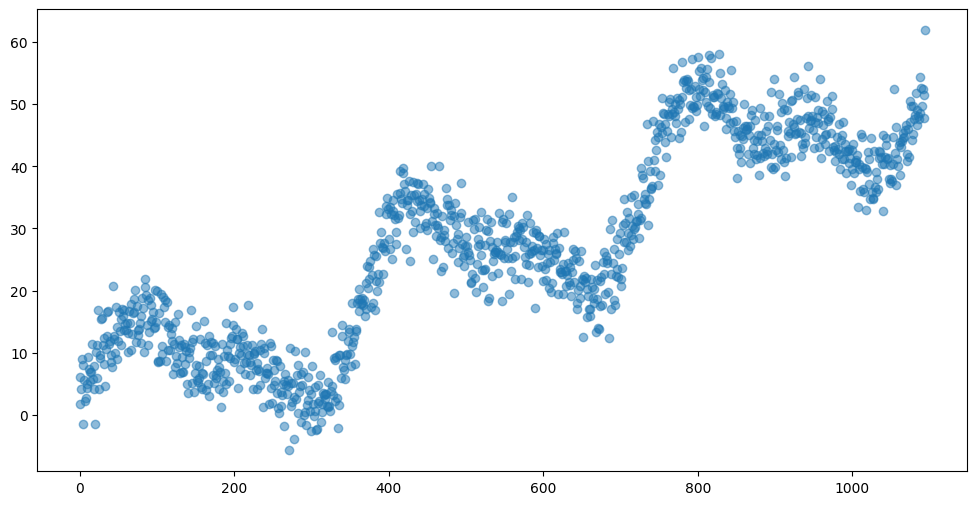

In [87]:
# Plot data and model fit
plt.figure(figsize=(12, 6))
plt.plot(t, Y, 'o', alpha=0.5, label='Observed data')

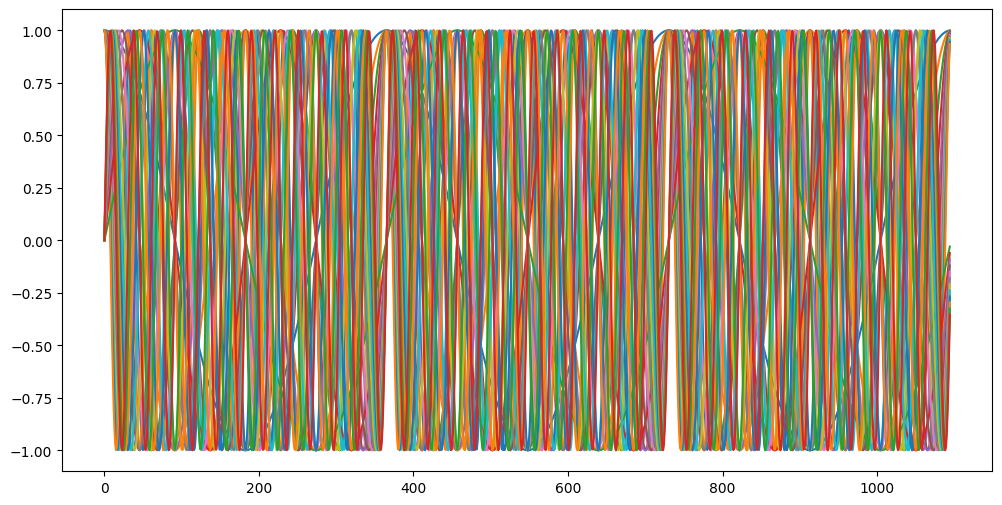

In [88]:
# Function to create Fourier features
def fourier_series(t, p=365.25, n=12):
    x = 2 * np.pi * np.arange(1, n+1) / p
    x = x * t[:, None]
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

# Create Fourier features
X = fourier_series(t)

# Plot data and model fit
plt.figure(figsize=(12, 6))
plt.plot(t, X, label='Fourier Series')

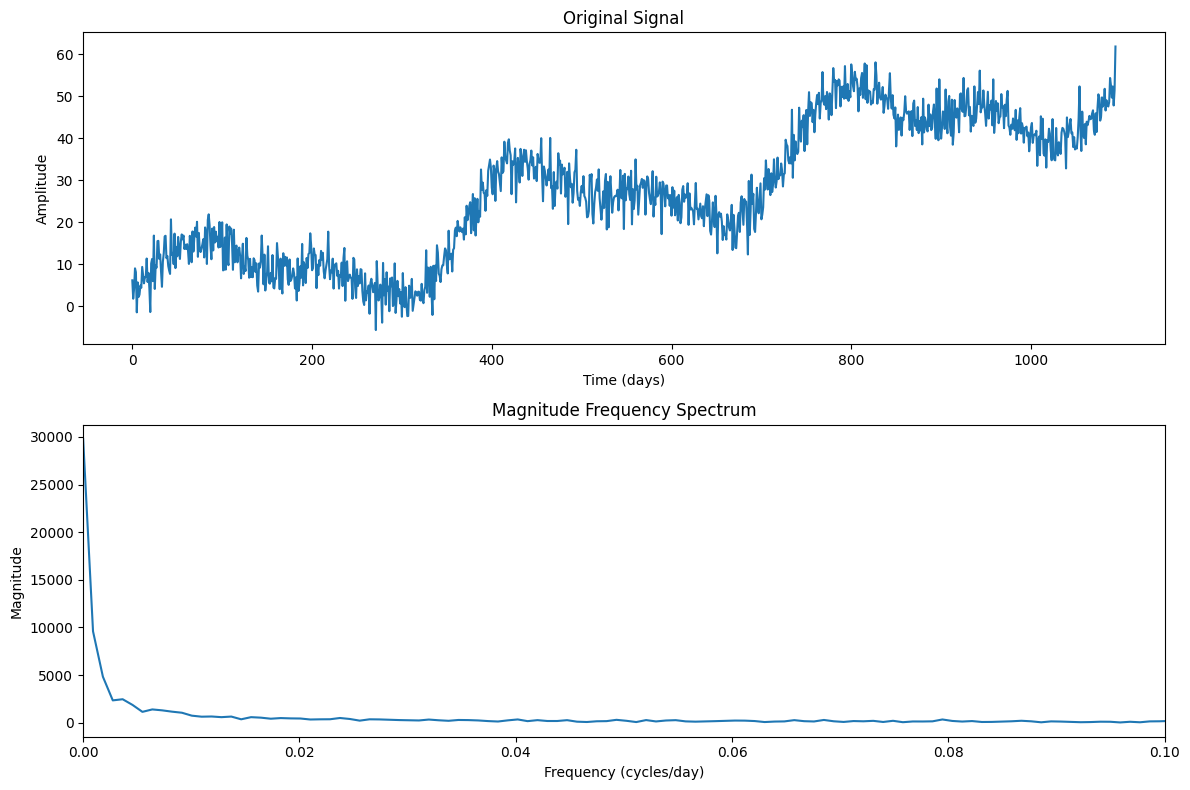

In [114]:
# Assuming you've already created X using the fourier_series function

# Calculate the number of features and the period
n_features = X.shape[1] // 2  # Number of sine-cosine pairs
# period = 365.25  # Assuming annual cycle

# Perform FFT
fft_result = np.fft.fft(Y)
frequencies = np.fft.fftfreq(len(t), d=1)  # Assuming daily data, so d=1 day

# Calculate the magnitude spectrum
magnitude_spectrum = np.abs(fft_result)

# Plot the original signal
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, Y)
plt.title('Original Signal')
plt.xlabel('Time (days)')
plt.ylabel('Amplitude')

# Plot the FFT result
plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], magnitude_spectrum[:len(frequencies)//2])
plt.title('Magnitude Frequency Spectrum')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Magnitude')
plt.xlim(0, 0.1)  # Limit x-axis to focus on lower frequencies

plt.tight_layout()
plt.show()

In [115]:
# Define and run the model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    # Linear trend
    trend = pm.Normal('trend', mu=0, sigma=0.1)
    
    # Model specification
    mu = intercept + pm.math.dot(X, beta) + trend * t
    # mu = intercept + trend * t
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Inference
    idata = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, beta, sigma, trend]


Output()

Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [99]:
# Print summary statistics
print(az.summary(idata, var_names=['intercept', 'trend', 'sigma']))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -0.084  0.220  -0.523    0.295      0.004    0.003    3001.0   
trend      0.050  0.000   0.049    0.051      0.000    0.000    2695.0   
sigma      3.462  0.075   3.329    3.604      0.001    0.001    4920.0   

           ess_tail  r_hat  
intercept    3130.0    1.0  
trend        3228.0    1.0  
sigma        3314.0    1.0  


In [106]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

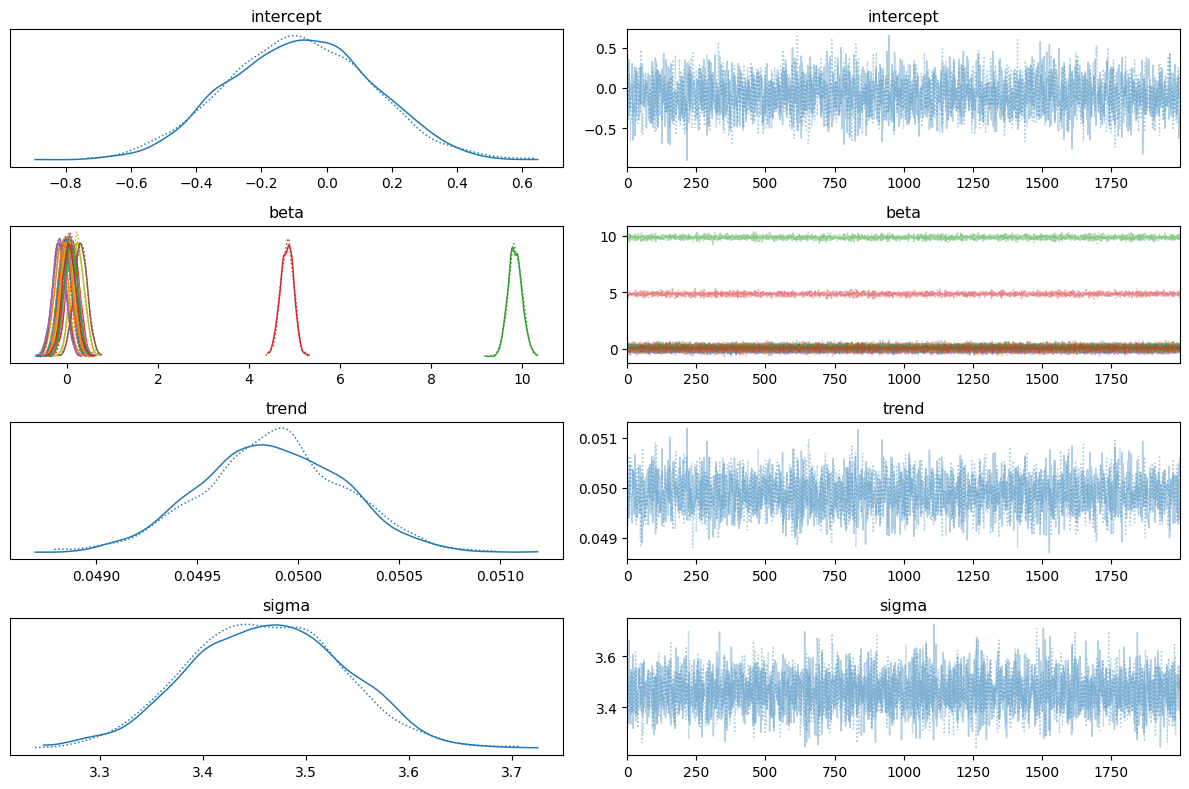

In [100]:
# Plot trace and posterior distributions
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [101]:
# Generate posterior predictive samples
ppc = pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)

Sampling: [Y_obs]


Output()

<Axes: xlabel='Y_obs'>

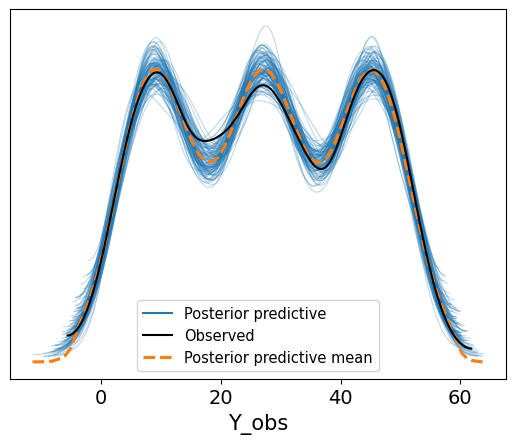

In [102]:
# Plot posterior predictive samples
az.plot_ppc(ppc, num_pp_samples=100, alpha=0.3)

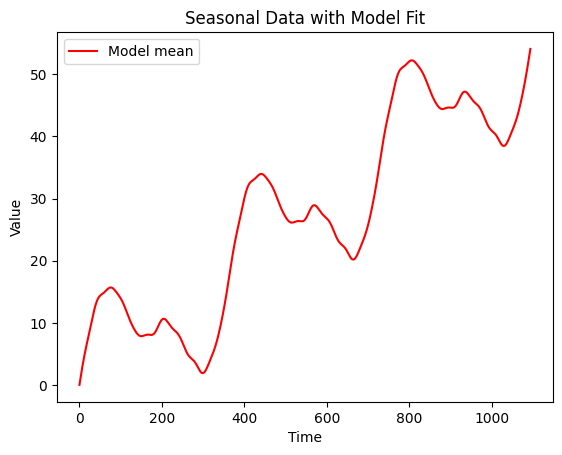

In [103]:
# Plot mean prediction
post_mean = az.summary(idata)['mean']
mean_prediction = (post_mean['intercept'] + 
                   np.dot(X, post_mean.filter(regex='^beta').values) + 
                   post_mean['trend'] * t)
plt.plot(t, mean_prediction, color='r', label='Model mean')

plt.legend()
plt.title('Seasonal Data with Model Fit')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

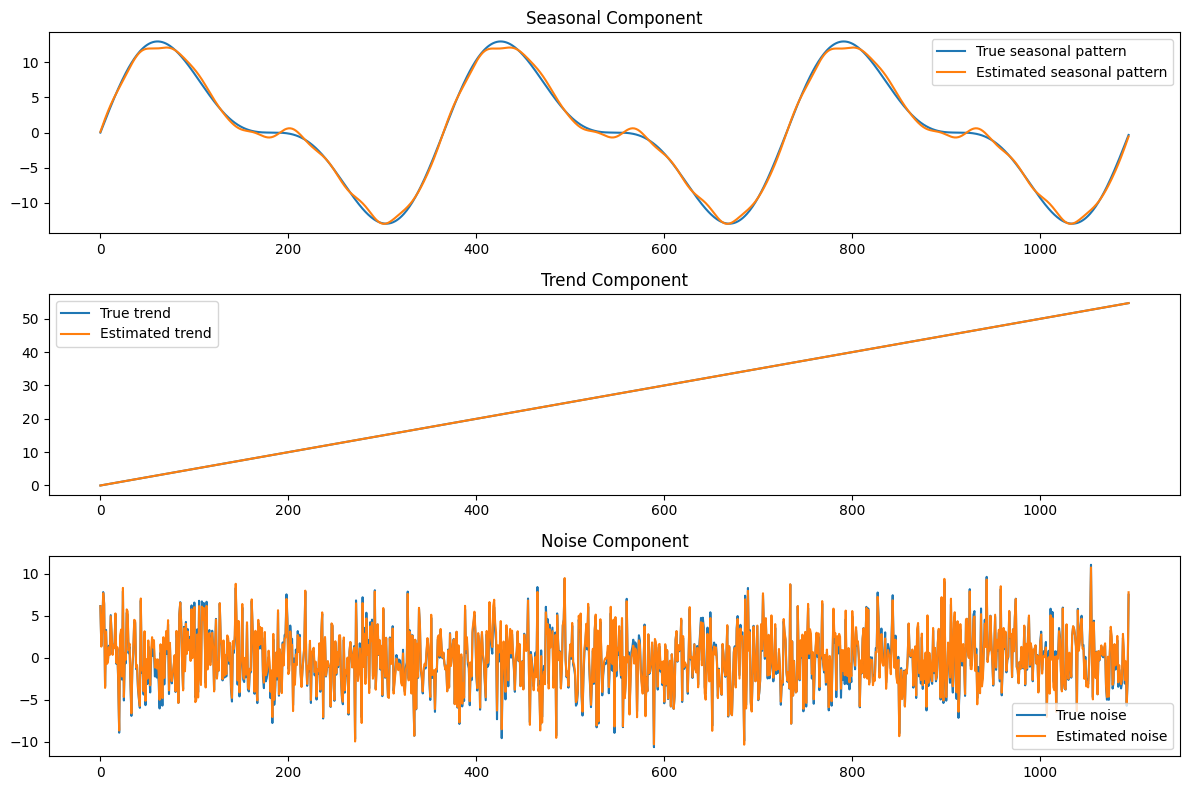

In [104]:
# Plot components
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(t, seasonal_pattern, label='True seasonal pattern')
plt.plot(t, np.dot(X, post_mean.filter(regex='^beta').values), label='Estimated seasonal pattern')
plt.legend()
plt.title('Seasonal Component')

plt.subplot(312)
# plt.plot(t, trend, label='True trend')
# plt.plot(t, post_mean['trend'] * t, label='Estimated trend')
# plt.legend()
# plt.title('Trend Component')
plt.plot(t, 0.05 * t, label='True trend')  # Use the original trend definition
plt.plot(t, post_mean['trend'] * t, label='Estimated trend')
plt.legend()
plt.title('Trend Component')

plt.subplot(313)
plt.plot(t, noise, label='True noise')
estimated_noise = Y - (np.dot(X, post_mean.filter(regex='^beta').values) + 
                       post_mean['trend'] * t + 
                       post_mean['intercept'])
plt.plot(t, estimated_noise, label='Estimated noise')
plt.legend()
plt.title('Noise Component')

plt.tight_layout()
plt.show()

In [105]:

# Print some additional information
print(f"N_eff / N_samples ratio for intercept: {az.ess(idata)['intercept'].mean() / len(idata.posterior.draw) * 100:.2f}%")
print(f"Rhat for intercept: {az.rhat(idata)['intercept'].mean():.3f}")

N_eff / N_samples ratio for intercept: 150.03%
Rhat for intercept: 1.001
